# setup

In [1]:
# !conda create --name steffen-voxelmorph-python3.7_tf2.4.1 python=3.7 tensorflow-gpu=2.4.1
# !pip install voxelmorph  # for all things voxelmorph/neurite
# !pip install tensorflow_addons  # for tqdm callbacks


# run in screen session


In [ ]:
# screen
# conda activate steffen-voxelmorph-python3.7_tf2.4.1
# conda install runipy
# runipy demo_brain3D.ipynb
# or
# jupyter nbconvert --to notebook --execute demo_brain3D.ipynb --output executed.ipynb

# Main

In [ ]:

# some imports we'll need throughout the demo
import os

# some third party very useful libraries
import tensorflow as tf
import tensorflow_addons as tfa  # for TQDM callback
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import nibabel as nib

# our libraries
import voxelmorph as vxm
import neurite as ne

# turn off eager for this
# need to do it due to some tf 2.0+ compatibility issues
tf.compat.v1.disable_eager_execution()

# some helpful functions
def plot_hist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(1, 2, 1)
  plt.plot(hist.epoch, hist.history['loss'], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.subplot(1, 2, 2)
  nb_epochs = len(hist.epoch) // 2
  plt.plot(hist.epoch[-nb_epochs:], hist.history['loss'][-nb_epochs:], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.show()


# generally useful callback
# unfortunately show_epoch_progress=True leaves a printout that we can't control (bad implementation in tfa...)
tqdm_cb = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, show_epoch_progress=False) 

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [2]:
# get the data
![ ! -f data-3d.tar ] && wget http://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.v1.0.tar -O  data-3d.tar
![ ! -d oasis-data-3d ] && mkdir oasis-data-3d && tar -xf data-3d.tar --directory oasis-data-3d

In [3]:
# prepare data
files = ['oasis-data-3d/' + f + '/' + 'aligned_norm.nii.gz' for f in os.listdir('oasis-data-3d') if f.startswith('OASIS_OAS1_')]
vols = [nib.load(f).get_fdata() for f in tqdm(files)]

  0%|          | 0/414 [00:00<?, ?it/s]

In [4]:
x_vols_full = np.expand_dims(np.stack(vols, 0), -1)
# x_vols_full = np.stack(vols, 0)
print('x_vols_full.shape: ', x_vols_full.shape)
x_vols = x_vols_full[:,:,5:165,10:202]
print('x_vols.shape: ', x_vols.shape)
vol_shape = x_vols.shape[1:-1]
# vol_shape = x_vols.shape[1:]

x_vols_full.shape:  (414, 160, 192, 224, 1)
x_vols.shape:  (414, 160, 160, 192, 1)


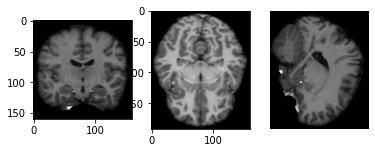

In [5]:
# visualize input data
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(x_vols[7,:,:,100], -1), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(x_vols[7,:,100,:], -1), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(x_vols[7,100,:,:], -1), cmap='gray')
plt.axis('off');

In [6]:
%%capture
# get the model
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Use fn_output_signature instead
Please report this to the TensorFlow team

In [7]:
# prepare a simple generator. 
def template_gen(x, batch_size):
  vol_shape = list(x.shape[1:-1])
  zero = np.zeros([batch_size] + vol_shape + [3])
  mean_atlas = np.repeat(  np.mean(x, 0, keepdims=True), batch_size, 0)

  while True:
    idx = np.random.randint(0, x.shape[0], batch_size)
    img = x[idx, ...]
    inputs = [mean_atlas, img]
    outputs = [img, zero, zero, zero]
    yield inputs, outputs


In [8]:
# let's make sure the sizes make sense
sample = next(template_gen(x_vols, 8))
[print(f.shape) for f in sample[0]], [print(f.shape) for f in sample[1]]

enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

print(vol_shape)

(8, 160, 160, 192, 1)
(8, 160, 160, 192, 1)
(8, 160, 160, 192, 1)
(8, 160, 160, 192, 3)
(8, 160, 160, 192, 3)
(8, 160, 160, 192, 3)
(160, 160, 192)


In [9]:
# creat model
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])


LocalParamWithInput: Consider using neuron.layers.LocalParam()


In [10]:
# prepare losses
image_loss_func = vxm.losses.MSE().loss
neg_loss_func = lambda _, y_pred: image_loss_func(model.references.atlas_tensor, y_pred)
losses = [image_loss_func, neg_loss_func, vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 1, 0.01]

model.compile('adam', loss=losses, loss_weights=loss_weights)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [30]:
# train
gen = template_gen(x_vols, batch_size=1)
hist = model.fit(gen, epochs=2000, steps_per_epoch=25, verbose=0, callbacks=[tqdm_cb])
# hist = model.fit(gen, epochs=3, steps_per_epoch=3, verbose=0, callbacks=[tqdm_cb])

Training:   0%|           0/1 ETA: ?s,  ?epochs/s

INFO:tensorflow:Assets written to: checkpoints/assets


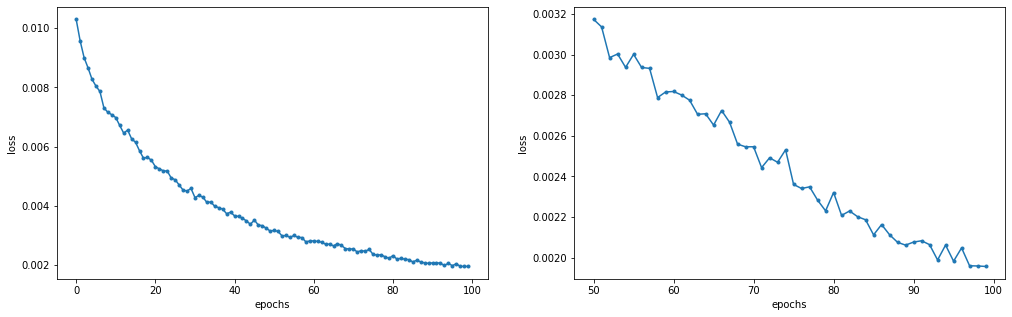

In [15]:
# visualize optimization
plot_hist(hist)

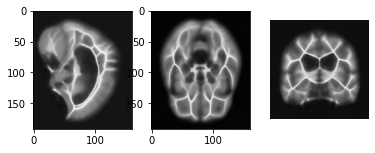

In [16]:
atlas = model.references.atlas_layer.get_weights()[0][..., 0]
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(atlas[100,:,:], -1), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(atlas[:,100,:], -1), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(atlas[:,:,100], -1), cmap='gray')
plt.axis('off');
plt.axis('off');

In [39]:
import time

secondsSinceEpoch = time.time()
timeObj = time.localtime(secondsSinceEpoch)

fileName = 'atlas_{}_{}_{}_{}_{}_{}.nii.gz'
fileName = fileName.format(timeObj.tm_year,timeObj.tm_mon,timeObj.tm_mday,timeObj.tm_hour,timeObj.tm_min,timeObj.tm_sec)

target_path = './output'

if not os.path.exists(target_path):
    os.mkdir(target_path)
    
nib.save(nib.Nifti1Image(atlas, np.eye(4)), os.path.join('output', fileName))  